## Check GPU Availability

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA available: True
GPU name: Tesla T4


## Load the dataset
The RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) is a high-quality, emotion-labeled dataset consisting of 7356 recordings of speech and song by 24 professional actors (12 male, 12 female). It includes 8 emotions — neutral, calm, happy, sad, angry, fearful, disgust, and surprised — expressed at two levels of intensity (normal and strong).

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


## Training and Evaluation

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Emotion mapping
emotion_dict = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Dataset
class RAVDESSDataset(Dataset):
    def __init__(self, file_list, labels, max_len=400, train=False):
        self.file_list = file_list
        self.labels = labels
        self.max_len = max_len
        self.train = train

        self.mel_transform = T.MelSpectrogram(
            sample_rate=22050, n_fft=1024, hop_length=512, n_mels=128
        )
        self.db_transform = T.AmplitudeToDB()

        # Optional augmentations
        self.freq_mask = T.FrequencyMasking(freq_mask_param=15)
        self.time_mask = T.TimeMasking(time_mask_param=35)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        waveform, sr = torchaudio.load(file_path)
        waveform = waveform.mean(dim=0).unsqueeze(0)

        mel_spec = self.mel_transform(waveform)
        if self.train:
            mel_spec = self.freq_mask(mel_spec)
            mel_spec = self.time_mask(mel_spec)

        mel_spec_db = self.db_transform(mel_spec)

        if mel_spec_db.size(2) < self.max_len:
            mel_spec_db = nn.functional.pad(mel_spec_db, (0, self.max_len - mel_spec_db.size(2)))
        else:
            mel_spec_db = mel_spec_db[:, :, :self.max_len]

        label = torch.tensor(self.labels[idx])
        return mel_spec_db, label

# CNN Model with Dropout
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Flatten(),
            nn.Linear(32 * 32 * 100, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Load dataset
def load_ravdess_dataset(root_dir):
    file_paths, labels = [], []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".wav"):
                emotion = int(file.split("-")[2]) - 1
                file_paths.append(os.path.join(subdir, file))
                labels.append(emotion)
    return file_paths, labels

# Training function
def train(model, loader, criterion, optimizer, device, scaler):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with autocast():
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(loader), correct / total

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with autocast():
                out = model(x)
                loss = criterion(out, y)
            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(loader), correct / total

# Main
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    root_dir = "/kaggle/input/ravdess-emotional-speech-audio"
    file_paths, labels = load_ravdess_dataset(root_dir)

    # First split: 70% train, 30% temp
    train_files, temp_files, train_labels, temp_labels = train_test_split(
        file_paths, labels, test_size=0.3, random_state=42, stratify=labels
    )

    # Second split: 15% val, 15% test (from temp)
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )

    train_dataset = RAVDESSDataset(train_files, train_labels, train=True)
    val_dataset   = RAVDESSDataset(val_files, val_labels)
    test_dataset  = RAVDESSDataset(test_files, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=16)
    test_loader  = DataLoader(test_dataset, batch_size=16)

    model = EmotionCNN(num_classes=8).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    scaler = GradScaler()

    best_val_loss = float('inf')
    patience, wait = 3, 0

    for epoch in range(30):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    # Final test evaluation (after early stopping)
    model.load_state_dict(torch.load("best_model.pt"))
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"\nFinal Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")


/tmp/ipython-input-3-1388392270.py:155: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3-1388392270.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-3-1388392270.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss=35.7763, Acc=0.2183 | Val Loss=1.7098, Acc=0.3403
Epoch 2: Train Loss=1.7129, Acc=0.3438 | Val Loss=1.6597, Acc=0.3472
Epoch 3: Train Loss=1.5620, Acc=0.4226 | Val Loss=1.5537, Acc=0.4051
Epoch 4: Train Loss=1.4269, Acc=0.4663 | Val Loss=1.4484, Acc=0.4815
Epoch 5: Train Loss=1.3655, Acc=0.4802 | Val Loss=1.3789, Acc=0.5255
Epoch 6: Train Loss=1.2825, Acc=0.5203 | Val Loss=1.3230, Acc=0.5440
Epoch 7: Train Loss=1.2163, Acc=0.5407 | Val Loss=1.2618, Acc=0.6042
Epoch 8: Train Loss=1.1285, Acc=0.5888 | Val Loss=1.2010, Acc=0.6389
Epoch 9: Train Loss=1.0524, Acc=0.6176 | Val Loss=1.1238, Acc=0.6412
Epoch 10: Train Loss=1.0199, Acc=0.6329 | Val Loss=1.1099, Acc=0.6713
Epoch 11: Train Loss=0.9567, Acc=0.6572 | Val Loss=1.0722, Acc=0.6921
Epoch 12: Train Loss=0.9160, Acc=0.6642 | Val Loss=1.0135, Acc=0.6944
Epoch 13: Train Loss=0.8145, Acc=0.7034 | Val Loss=1.0237, Acc=0.6991
Epoch 14: Train Loss=0.8229, Acc=0.7088 | Val Loss=1.0256, Acc=0.6968
Epoch 15: Train Loss=0.7435,

**INFERENCES**<br>
- The model shows a consistent improvement across epochs in both training and validation accuracy, indicating successful learning.

- Early stopping was triggered after epoch 20, preventing overfitting and ensuring generalization.

- The best validation accuracy achieved was **~77%**, and the final test accuracy reached **80%**, suggesting the model performs reliably on unseen data.

- The gradual reduction in validation loss and alignment with training loss confirms stable training behavior.

- The slight increase in validation loss in later epochs suggests the model was beginning to overfit, which was mitigated by the early stopping mechanism.



## Save the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), '/content/drive/MyDrive/best_model.pt')

Mounted at /content/drive


## Vizualizations

### 1. Confusion Matrix

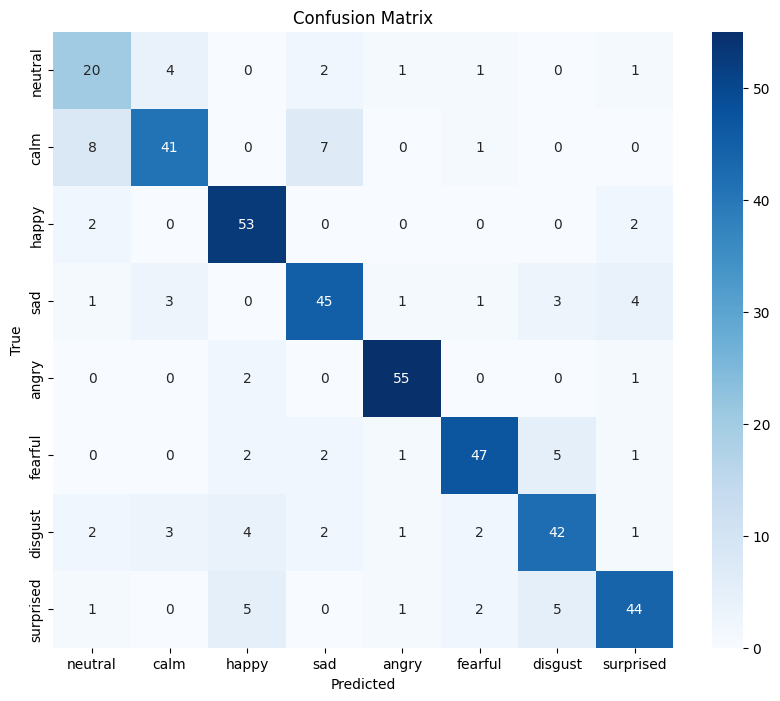

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import torch

# Label names
label_names = list(emotion_dict.values())

# Collect all predictions
all_preds, all_probs, all_labels = [], [], []
model.eval()

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# 1. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### 2. Classification Report

In [ ]:
print("📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_names))

📋 Classification Report:

              precision    recall  f1-score   support

     neutral       0.59      0.69      0.63        29
        calm       0.80      0.72      0.76        57
       happy       0.80      0.93      0.86        57
         sad       0.78      0.78      0.78        58
       angry       0.92      0.95      0.93        58
     fearful       0.87      0.81      0.84        58
     disgust       0.76      0.74      0.75        57
   surprised       0.81      0.76      0.79        58

    accuracy                           0.80       432
   macro avg       0.79      0.80      0.79       432
weighted avg       0.81      0.80      0.80       432



### 3. ROC Curve

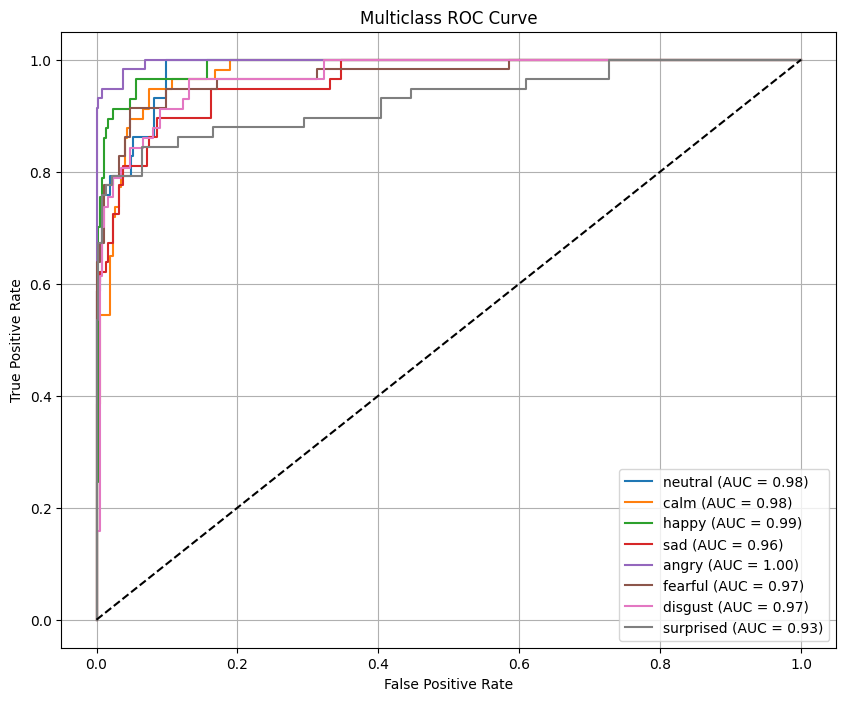

In [ ]:
from sklearn.preprocessing import label_binarize
n_classes = len(label_names)
y_true_bin = label_binarize(all_labels, classes=range(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 4. Train vs Val plots

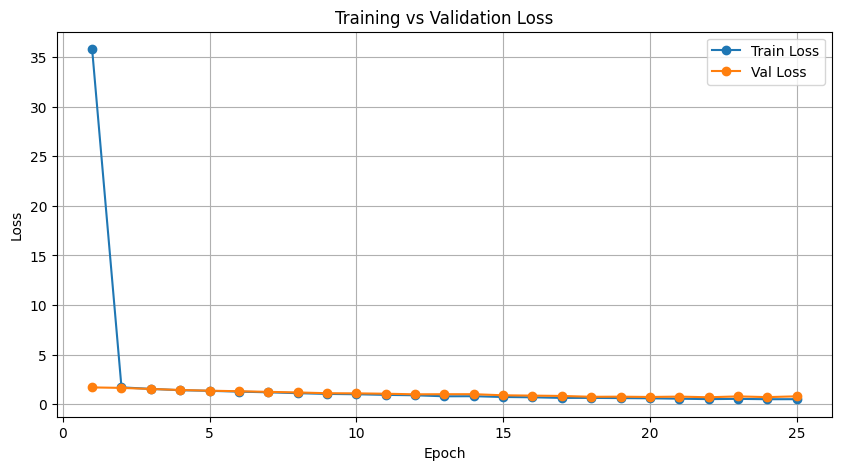

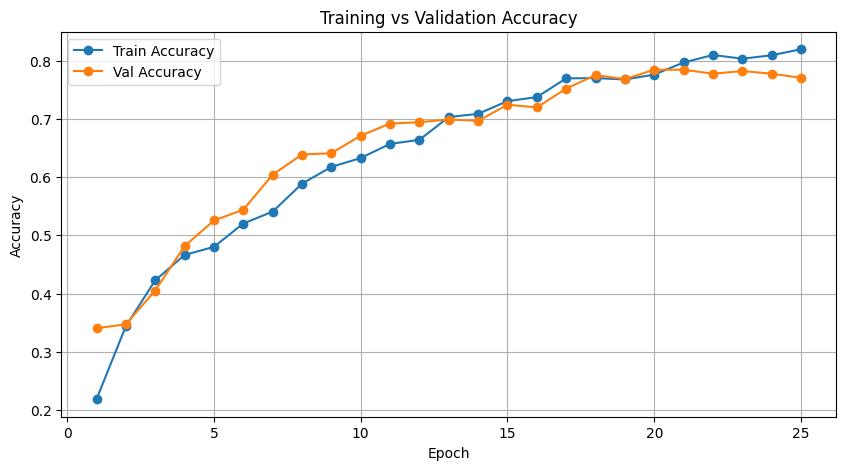

In [ ]:
import matplotlib.pyplot as plt
import re

# Paste your training logs here as a multiline string
log_text = """
Epoch 1: Train Loss=35.7763, Acc=0.2183 | Val Loss=1.7098, Acc=0.3403
Epoch 2: Train Loss=1.7129, Acc=0.3438 | Val Loss=1.6597, Acc=0.3472
Epoch 3: Train Loss=1.5620, Acc=0.4226 | Val Loss=1.5537, Acc=0.4051
Epoch 4: Train Loss=1.4269, Acc=0.4663 | Val Loss=1.4484, Acc=0.4815
Epoch 5: Train Loss=1.3655, Acc=0.4802 | Val Loss=1.3789, Acc=0.5255
Epoch 6: Train Loss=1.2825, Acc=0.5203 | Val Loss=1.3230, Acc=0.5440
Epoch 7: Train Loss=1.2163, Acc=0.5407 | Val Loss=1.2618, Acc=0.6042
Epoch 8: Train Loss=1.1285, Acc=0.5888 | Val Loss=1.2010, Acc=0.6389
Epoch 9: Train Loss=1.0524, Acc=0.6176 | Val Loss=1.1238, Acc=0.6412
Epoch 10: Train Loss=1.0199, Acc=0.6329 | Val Loss=1.1099, Acc=0.6713
Epoch 11: Train Loss=0.9567, Acc=0.6572 | Val Loss=1.0722, Acc=0.6921
Epoch 12: Train Loss=0.9160, Acc=0.6642 | Val Loss=1.0135, Acc=0.6944
Epoch 13: Train Loss=0.8145, Acc=0.7034 | Val Loss=1.0237, Acc=0.6991
Epoch 14: Train Loss=0.8229, Acc=0.7088 | Val Loss=1.0256, Acc=0.6968
Epoch 15: Train Loss=0.7435, Acc=0.7307 | Val Loss=0.9147, Acc=0.7245
Epoch 16: Train Loss=0.7140, Acc=0.7376 | Val Loss=0.8815, Acc=0.7199
Epoch 17: Train Loss=0.6520, Acc=0.7698 | Val Loss=0.8481, Acc=0.7523
Epoch 18: Train Loss=0.6531, Acc=0.7703 | Val Loss=0.7636, Acc=0.7755
Epoch 19: Train Loss=0.6329, Acc=0.7679 | Val Loss=0.7760, Acc=0.7685
Epoch 20: Train Loss=0.6124, Acc=0.7763 | Val Loss=0.7453, Acc=0.7847
Epoch 21: Train Loss=0.5712, Acc=0.7971 | Val Loss=0.7826, Acc=0.7847
Epoch 22: Train Loss=0.5297, Acc=0.8100 | Val Loss=0.7154, Acc=0.7778
Epoch 23: Train Loss=0.5555, Acc=0.8036 | Val Loss=0.8039, Acc=0.7824
Epoch 24: Train Loss=0.5190, Acc=0.8095 | Val Loss=0.7308, Acc=0.7778
Epoch 25: Train Loss=0.5235, Acc=0.8199 | Val Loss=0.8108, Acc=0.7708
"""

# Extract metrics using regex
train_loss, val_loss, train_acc, val_acc = [], [], [], []
for line in log_text.strip().splitlines():
    match = re.search(r"Train Loss=([\d.]+), Acc=([\d.]+) \| Val Loss=([\d.]+), Acc=([\d.]+)", line)
    if match:
        train_loss.append(float(match.group(1)))
        train_acc.append(float(match.group(2)))
        val_loss.append(float(match.group(3)))
        val_acc.append(float(match.group(4)))

epochs = list(range(1, len(train_loss)+1))

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()
